In [122]:
import numpy as np
from tqdm.notebook import tqdm
import pickle

In [23]:
import geopandas

#path_to_data = geopandas.datasets.get_path("stations")
dfS = geopandas.read_file("stations.geojson")
dfS = dfS.where(dfS['class_fr']=='Gare').dropna()
dfL = geopandas.read_file("geosporen.geojson")

In [84]:
LID = dfL['linecnum'].unique()
SID = dfS['symbolicname'].unique()
nL, nS = len(LID), len(SID)
print(nL, nS)

265 414


In [133]:
def save_array(A, filename):
    file = open(filename, "wb")
    pickle.dump(A, file)
    file.close()
    
def load_array(filename):
    file = open(filename, "rb")
    return pickle.load(file)

In [131]:
LS = np.zeros((nL, nS))

for s in dfS.iterrows():
    p = s[1].geometry
    Lanes = set()
    for l in dfL.iterrows():
        lane = l[1].geometry
        if l[1].geometry != None and p != None and lane.distance(p) < 10e-3: 
            Lanes.add(l[1].linecnum)
            LS[np.where(LID==l[1].linecnum)[0], np.where(SID==s[1].symbolicname)[0]] = 1

In [141]:
save_array(LS, "links_btw_stations.pkl")

In [143]:
LS = load_array("links_btw_stations.pkl")

In [119]:
def is_linked(dfL, ID1, ID2, LIDs):
    ids1 = LIDs[ID1]
    ids2 = LIDs[ID2]
    for i in ids1:
        for j in ids2:
            if dfL.geometry[i] != None and dfL.geometry[j] != None:
                if dfL.geometry[i].distance(dfL.geometry[j]) < 10e-3:
                    return True
    return False

In [106]:
LIDs = {}
for i in LID:
    LIDs[i] = np.where(dfL==i)[0]

In [120]:
# Really slow -> Load the pickle instead
L = np.zeros((nL, nL))
for i in tqdm(range(nL)):
    for j in range(i, nL):
        if is_linked(dfL, LID[i], LID[j], LIDs):
            L[i,j] = 1
            L[j,i] = 1

In [145]:
save_array(L, "linked_lanes.pkl")

In [146]:
L = load_array("linked_lanes.pkl")

FNWHZ


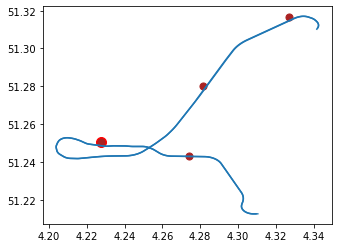

In [173]:
s = 1
print(SID[s])
base = dfS.where(dfS.symbolicname==SID[s]).dropna().plot(color='red', markersize=100)
for l in range(nL):
    if LS[l,s] == 1:
        DF = dfL.where(dfL.linecnum==LID[l]).dropna()
        DF.plot(ax=base)
        for s2 in range(nS):
            if LS[l,s2] == 1:
                dfS.where(dfS.symbolicname==SID[s2]).dropna().plot(ax = base, color='#AA2222', markersize=50)